In [125]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import skgstat as skg
import gstools as gs
from pykrige.ok import OrdinaryKriging
from pykrige.uk import UniversalKriging
from pprint import pprint
from scipy.spatial.distance import pdist
from skgstat import Variogram
from haversine import haversine 
from scipy import stats

In [126]:
# Load municipal data
municipals = pd.read_csv('filtered_RJ_lat_long_data.csv')

# Load weather station data
stations = pd.read_csv('stations_RIO.csv')

# Load weekly weather data
weekly_data = pd.read_csv('filtered_weather_data_2012_2022_RIO.csv')


In [127]:
stations = stations.rename(columns={'id_station': 'ESTACAO'})

In [128]:
print(stations)

   region state                  city_station ESTACAO        lat        lon  \
0      SE    RJ             ECOLOGIA AGRICOLA    A601 -22.800000 -43.683333   
1      SE    RJ                     MARAMBAIA    A602 -23.050000 -43.600000   
2      SE    RJ                         XEREM    A603 -22.589722 -43.282222   
3      SE    RJ                       CAMBUCI    A604 -21.566667 -41.950000   
4      SE    RJ               ARRAIAL DO CABO    A606 -22.983333 -42.016667   
5      SE    RJ                        CAMPOS    A607 -21.716667 -41.350000   
6      SE    RJ                         MACAE    A608 -22.383333 -41.816667   
7      SE    RJ                       RESENDE    A609 -22.450000 -44.450000   
8      SE    RJ                 PICO DO COUTO    A610 -22.481667 -43.291389   
9      SE    RJ                       VALENCA    A611 -22.350000 -43.700000   
10     SE    RJ                   TERESOPOLIS    A618 -22.448889 -42.987222   
11     SE    RJ                        PARATI    A61

In [129]:
# Example: Filter necessary columns from weekly_data
weekly_data = weekly_data[['ESTACAO', 'week', 'precipitation_avg','precipitation_max']]

# Merge precipitation data with station information
stations_with_data = stations.merge(weekly_data, left_on='ESTACAO', right_on='ESTACAO')

print(stations_with_data)

      region state              city_station ESTACAO        lat        lon  \
0         SE    RJ         ECOLOGIA AGRICOLA    A601 -22.800000 -43.683333   
1         SE    RJ         ECOLOGIA AGRICOLA    A601 -22.800000 -43.683333   
2         SE    RJ         ECOLOGIA AGRICOLA    A601 -22.800000 -43.683333   
3         SE    RJ         ECOLOGIA AGRICOLA    A601 -22.800000 -43.683333   
4         SE    RJ         ECOLOGIA AGRICOLA    A601 -22.800000 -43.683333   
...      ...   ...                       ...     ...        ...        ...   
11941     SE    RJ  Paty do Alferes - Avelar    A637 -22.347222 -43.417778   
11942     SE    RJ  Paty do Alferes - Avelar    A637 -22.347222 -43.417778   
11943     SE    RJ  Paty do Alferes - Avelar    A637 -22.347222 -43.417778   
11944     SE    RJ  Paty do Alferes - Avelar    A637 -22.347222 -43.417778   
11945     SE    RJ  Paty do Alferes - Avelar    A637 -22.347222 -43.417778   

         lvl record_first record_last    week  precipitation_av

In [130]:
stations_with_data = stations_with_data[['ESTACAO', 'lat', 'lon','lvl','week','precipitation_avg','precipitation_max']]
print(stations_with_data)

      ESTACAO        lat        lon    lvl    week  precipitation_avg  \
0        A601 -22.800000 -43.683333   33.0  201201          14.171429   
1        A601 -22.800000 -43.683333   33.0  201202           5.057143   
2        A601 -22.800000 -43.683333   33.0  201203           2.428571   
3        A601 -22.800000 -43.683333   33.0  201204           1.028571   
4        A601 -22.800000 -43.683333   33.0  201205           2.400000   
...       ...        ...        ...    ...     ...                ...   
11941    A637 -22.347222 -43.417778  508.0  202248           4.285714   
11942    A637 -22.347222 -43.417778  508.0  202249           2.600000   
11943    A637 -22.347222 -43.417778  508.0  202250           1.142857   
11944    A637 -22.347222 -43.417778  508.0  202251           0.714286   
11945    A637 -22.347222 -43.417778  508.0  202252           4.066667   

       precipitation_max  
0                   66.2  
1                   22.8  
2                    7.0  
3              

In [131]:
# Extract coordinates and elevation from stations
stations_coords = stations[['lat', 'lon']].values

# Extract coordinates and elevation from municipalities
municipals_coords = municipals[['LONG', 'LAT', 'ALT']].values
stations_coords_2 = stations[['lat', 'lon','lvl']].values
print(stations_coords)
print(stations_coords_2)

[[-22.8        -43.68333333]
 [-23.05       -43.6       ]
 [-22.58972221 -43.28222221]
 [-21.56666666 -41.95      ]
 [-22.98333333 -42.01666666]
 [-21.71666666 -41.35      ]
 [-22.38333333 -41.81666667]
 [-22.45       -44.45      ]
 [-22.48166666 -43.29138888]
 [-22.35       -43.7       ]
 [-22.44888888 -42.98722221]
 [-23.22333332 -44.72666666]
 [-22.86083333 -43.41111111]
 [-22.98833333 -43.19027777]
 [-22.04166666 -41.05194444]
 [-22.33305554 -42.67722221]
 [-22.64583333 -42.41583333]
 [-22.8711111  -42.60916666]
 [-22.09833333 -43.20861111]
 [-22.65361111 -44.04083333]
 [-22.97583332 -44.30333333]
 [-22.37388888 -44.70305555]
 [-22.93972221 -43.40277777]
 [-22.86749999 -43.10194444]
 [-21.9386111  -42.60083333]
 [-21.95055555 -42.01055555]
 [-22.34722221 -43.41777777]]
[[ -22.8         -43.68333333   33.        ]
 [ -23.05        -43.6           9.7       ]
 [ -22.58972221  -43.28222221   33.        ]
 [ -21.56666666  -41.95         35.        ]
 [ -22.98333333  -42.01666666    4. 

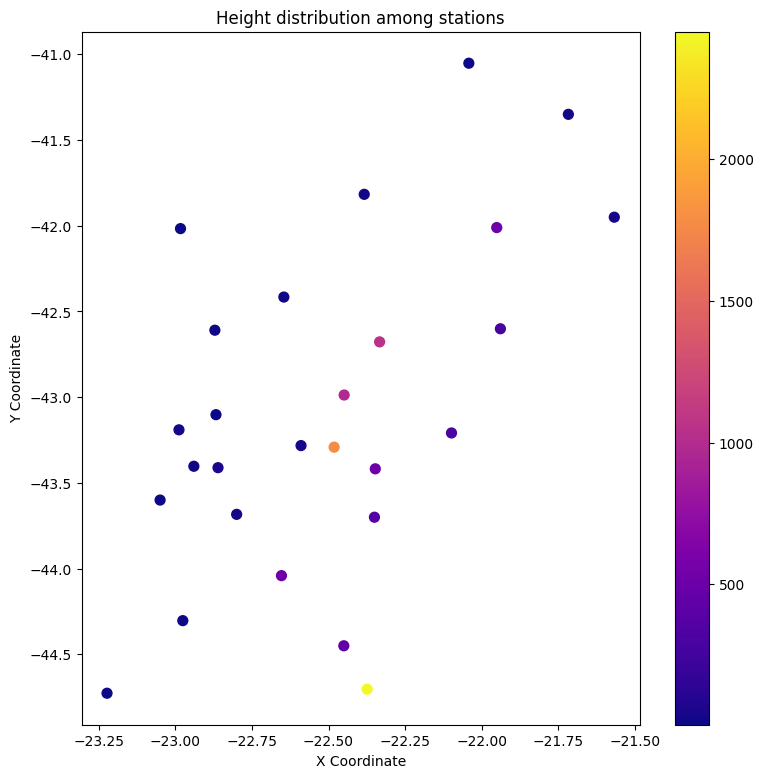

In [132]:
fig, ax = plt.subplots(1, 1, figsize=(9, 9))
art = ax.scatter(stations[['lat']].values, stations[['lon']].values, s=50, c=stations[['lvl']].values.flatten(), cmap='plasma')
plt.colorbar(art)  
plt.title("Height distribution among stations")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.show()


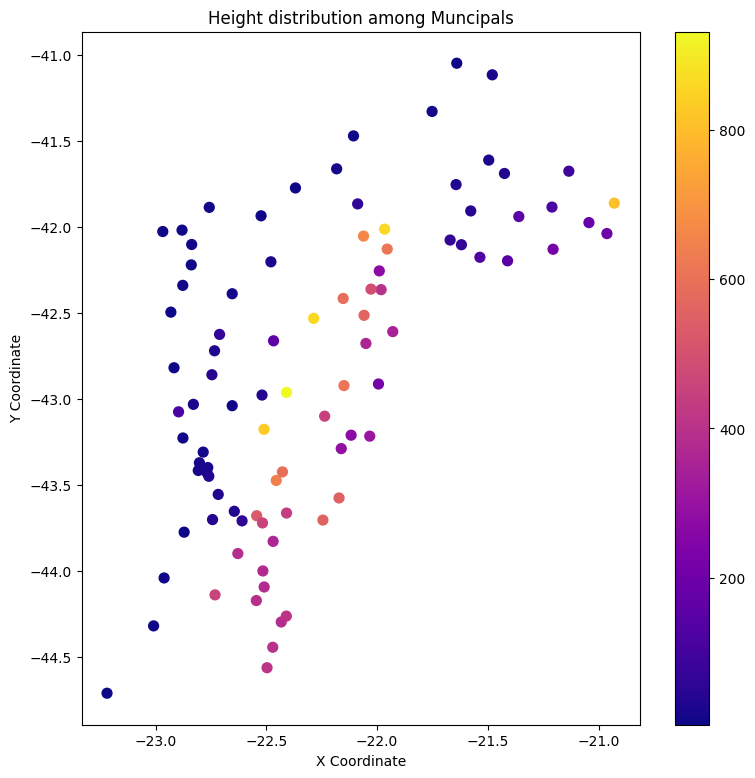

In [133]:
fig, ax = plt.subplots(1, 1, figsize=(9, 9))
art = ax.scatter(municipals[['LAT']].values, municipals[['LONG']].values, s=50, c=municipals[['ALT']].values.flatten(), cmap='plasma')
plt.colorbar(art)  
plt.title("Height distribution among Muncipals")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.show()

In [134]:
def calculate_distances(lat_lon_values):
    n = len(lat_lon_values)
    distances = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i + 1, n):
            distances[i, j] = haversine(lat_lon_values[i], lat_lon_values[j])
            distances[j, i] = distances[i, j]
    
    return distances

# Convert lat/lon to distances
lat_lon_values = stations[['lat', 'lon']].values
distance_matrix = calculate_distances(lat_lon_values)
print(distance_matrix)

[[  0.          29.0793198   47.3273901  225.07225424 171.9410439
  268.63689404 197.15623312  87.78691542  53.58069983  50.06703903
   81.41860157 116.69640182  28.70669949  54.67591538 283.31241234
  115.62214685 131.12547    110.3638528   92.01897634  40.11660058
   66.45426972 114.91337268  32.67414641  60.05231078 146.8466914
  196.22587791  57.25579972]
 [ 29.0793198    0.          60.66486072 236.67255938 162.21170567
  274.76191082 197.36315943 109.76498925  70.67503347  78.50960146
   91.73931646 116.80436453  28.57428146  42.48836033 284.67850326
  123.76117102 129.39664235 103.37847496 113.19398231  63.11225254
   72.45402474 135.84262766  23.61996849  54.88376444 160.65065643
  203.97583867  80.3500141 ]
 [ 47.3273901   60.66486072   0.         178.28158727 136.92349479
  221.406667   152.31059583 120.95122545  12.0520731   50.53066366
   34.10875124 163.86662084  32.91719163  45.31472067 237.37504387
   68.40736723  89.14737731  75.78802651  55.16200095  78.18736888
  113.

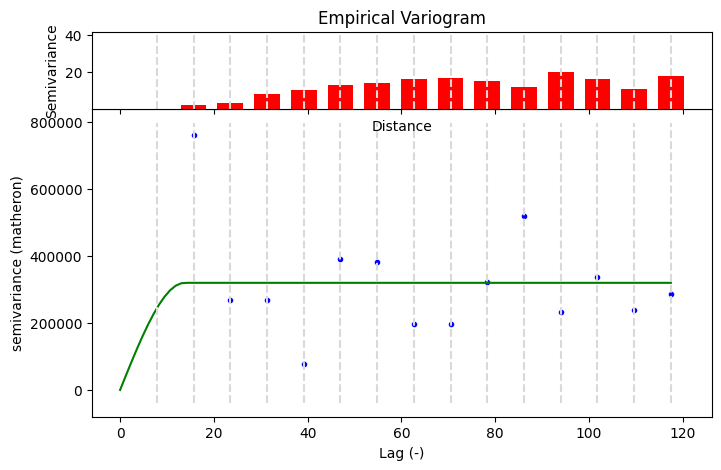

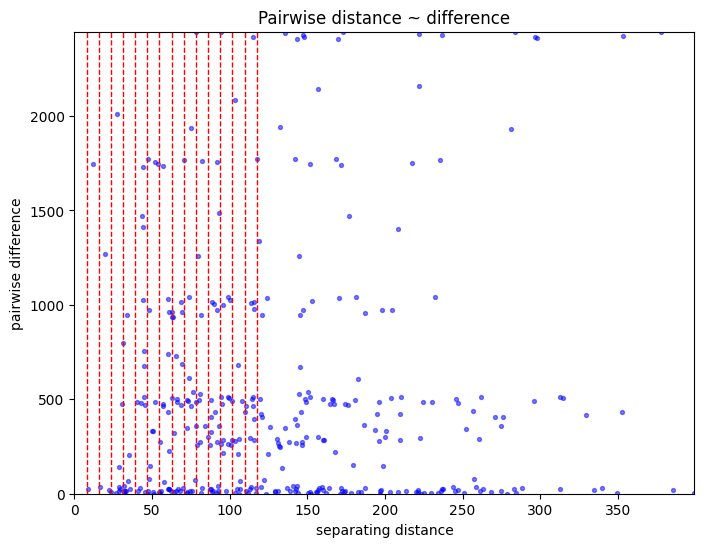

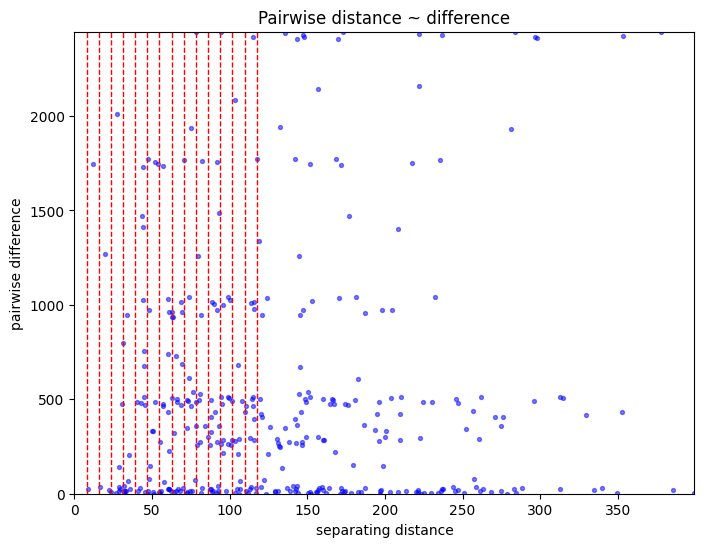

In [135]:
# Define the number of lags
N = 15

# Define the haversine distance function
def haversine_dist(x, y):
    return haversine(x, y)

# Create the empirical variogram
V = Variogram(
    stations[['lat', 'lon']].values, 
    stations[['lvl']].values.flatten(), 
    maxlag='median', 
    n_lags=N, 
    normalize=False, 
    dist_func=haversine_dist
)


# Plot the empirical variogram
fig = V.plot(show=False)
plt.title('Empirical Variogram')
plt.xlabel('Distance')
plt.ylabel('Semivariance')
plt.show()
# Print the description of the variogram
fig = V.distance_difference_plot(show=False)
fig


In [136]:
print(stations[['lat', 'lon']].values)
print(stations[['lat', 'lon']].shape)
lat_lon_values = stations[['lat', 'lon']].values
print(haversine_dist(lat_lon_values[0], lat_lon_values[1]))


[[-22.8        -43.68333333]
 [-23.05       -43.6       ]
 [-22.58972221 -43.28222221]
 [-21.56666666 -41.95      ]
 [-22.98333333 -42.01666666]
 [-21.71666666 -41.35      ]
 [-22.38333333 -41.81666667]
 [-22.45       -44.45      ]
 [-22.48166666 -43.29138888]
 [-22.35       -43.7       ]
 [-22.44888888 -42.98722221]
 [-23.22333332 -44.72666666]
 [-22.86083333 -43.41111111]
 [-22.98833333 -43.19027777]
 [-22.04166666 -41.05194444]
 [-22.33305554 -42.67722221]
 [-22.64583333 -42.41583333]
 [-22.8711111  -42.60916666]
 [-22.09833333 -43.20861111]
 [-22.65361111 -44.04083333]
 [-22.97583332 -44.30333333]
 [-22.37388888 -44.70305555]
 [-22.93972221 -43.40277777]
 [-22.86749999 -43.10194444]
 [-21.9386111  -42.60083333]
 [-21.95055555 -42.01055555]
 [-22.34722221 -43.41777777]]
(27, 2)
29.07931979712805


[3.49650786 2.27212692 3.49650786 3.55534835 1.38629686 3.21887622
 3.46573622 6.08652472 7.48268183 5.90536188 6.88755258 1.60943991
 3.80666271 3.73766986 2.07944279 6.95272865 2.94443951 2.77258935
 5.72031181 6.24610678 1.79176114 7.80384331 2.99573277 1.79176114
 5.68017264 6.24804289 6.23048147]


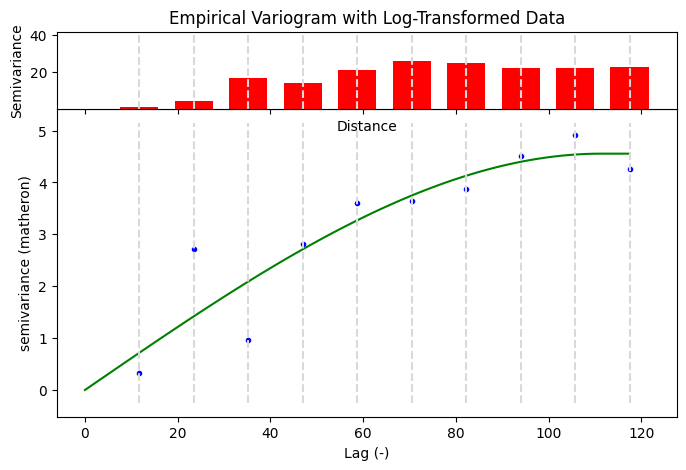

{'model': 'spherical', 'estimator': 'matheron', 'dist_func': '__main__.haversine_dist', 'normalized_effective_range': 13068.858270796069, 'normalized_sill': 22.337100101782344, 'normalized_nugget': 0, 'effective_range': 111.28741442085442, 'sill': 4.55397872643891, 'nugget': 0, 'params': {'estimator': 'matheron', 'model': 'spherical', 'dist_func': '<function haversine_dist at 0x00000216697DBF60>', 'bin_func': 'even', 'normalize': False, 'fit_method': 'trf', 'fit_sigma': None, 'use_nugget': False, 'maxlag': 117.43338938016574, 'n_lags': 10, 'verbose': False}, 'kwargs': {}}


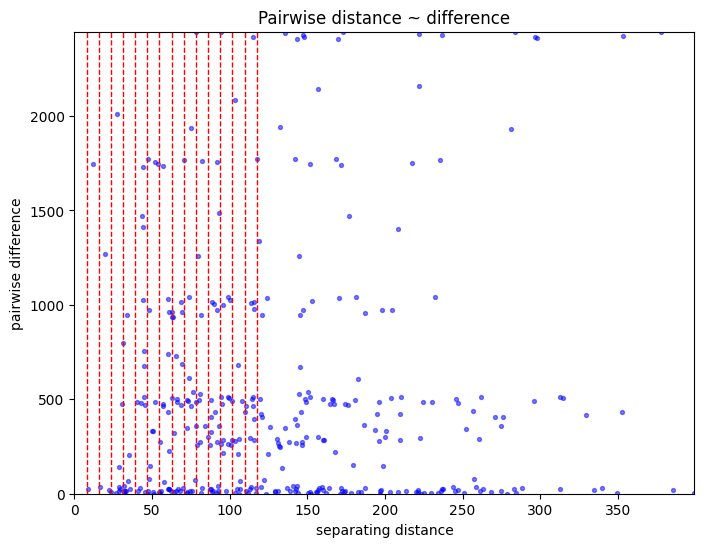

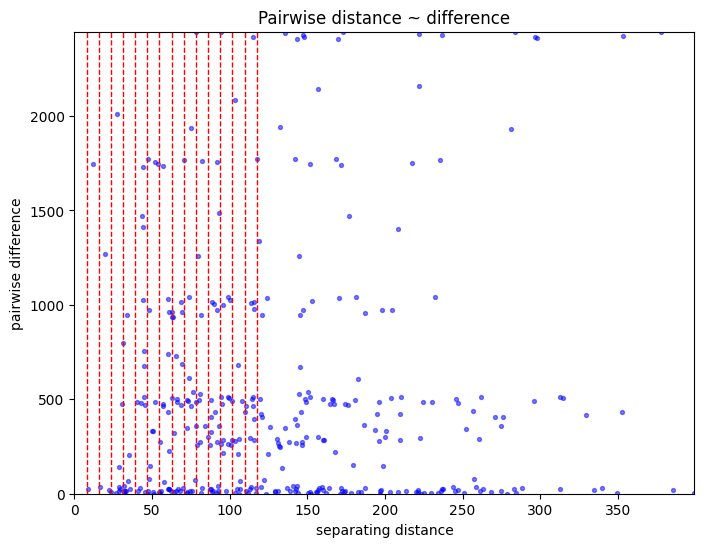

In [149]:
constant = 1e-5
stations['lvl_log'] = np.log(stations['lvl'] + constant)

# 2. Identify and Remove Outliers
# Using Z-score method to identify outliers
z_scores = np.abs(stats.zscore(stations['lvl_log']))
stations_no_outliers = stations[z_scores < 3]  # Removing outliers with Z-score > 3

# 3. Create the Variogram with Transformed Data
lat_lon_values = stations_no_outliers[['lat', 'lon']].values
levels_log = stations_no_outliers['lvl_log'].values.flatten()
print(levels_log)

# Create the variogram
V_log = skg.Variogram(
    lat_lon_values,
    levels_log,
    maxlag='median',
    n_lags=10,
    dist_func=haversine_dist  # Ensure this is suitable for your data
)

# Fit the variogram model
V_log.fit()  # Experiment with other models if necessary

# 4. Plot the Variogram
fig = V_log.plot(show=False)
plt.title('Empirical Variogram with Log-Transformed Data')
plt.xlabel('Distance')
plt.ylabel('Semivariance')
plt.show()

# 5. Print description for further analysis
print(V_log.describe())
fig = V.distance_difference_plot(show=False)
fig

[3.49650786 2.27212692 3.49650786 3.55534835 1.38629686 3.21887622
 3.46573622 6.08652472 7.48268183 5.90536188 6.88755258 1.60943991
 3.80666271 3.73766986 2.07944279 6.95272865 2.94443951 2.77258935
 5.72031181 6.24610678 1.79176114 7.80384331 2.99573277 1.79176114
 5.68017264 6.24804289 6.23048147]


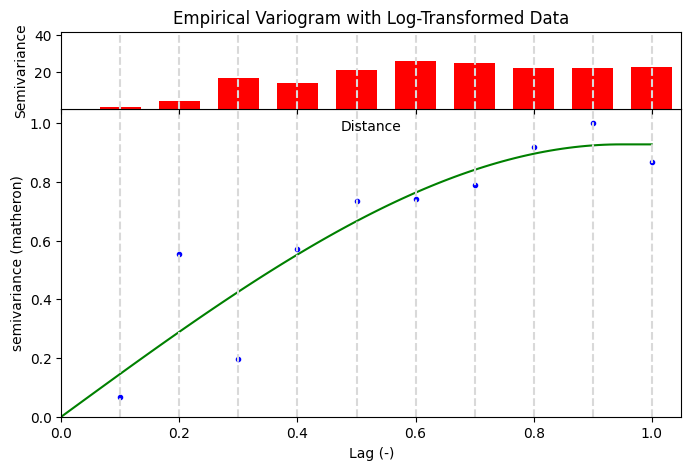

{'model': 'spherical', 'estimator': 'matheron', 'dist_func': '__main__.haversine_dist', 'normalized_effective_range': 13068.858270796069, 'normalized_sill': 22.337100101782344, 'normalized_nugget': 0, 'effective_range': 111.28741442085442, 'sill': 4.55397872643891, 'nugget': 0, 'params': {'estimator': 'matheron', 'model': 'spherical', 'dist_func': '<function haversine_dist at 0x00000216697DBF60>', 'bin_func': 'even', 'normalize': True, 'fit_method': 'trf', 'fit_sigma': None, 'use_nugget': False, 'maxlag': 117.43338938016574, 'n_lags': 10, 'verbose': False}, 'kwargs': {}}


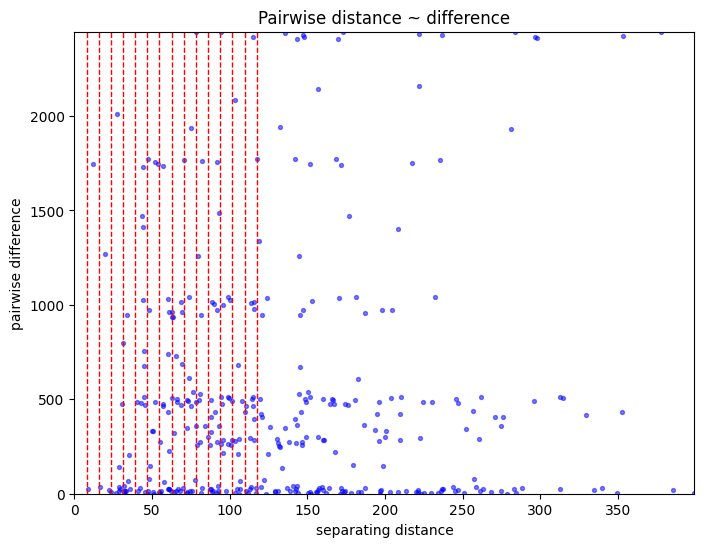

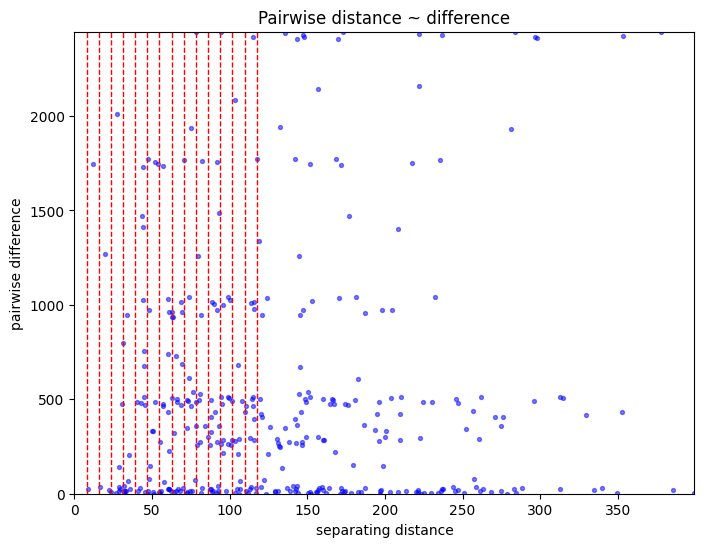

In [173]:
constant = 1e-5
stations['lvl_log'] = np.log(stations['lvl'] + constant)

# 2. Identify and Remove Outliers
# Using Z-score method to identify outliers
z_scores = np.abs(stats.zscore(stations['lvl_log']))
stations_no_outliers = stations[z_scores < 3]  # Removing outliers with Z-score > 3

# 3. Create the Variogram with Transformed Data
lat_lon_values = stations_no_outliers[['lat', 'lon']].values
levels_log = stations_no_outliers['lvl_log'].values.flatten()
print(levels_log)

# Create the variogram
V_log = skg.Variogram(
    lat_lon_values,
    levels_log,
    maxlag='median',
    n_lags=10,
    normalize=True,
    dist_func=haversine_dist  # Ensure this is suitable for your data
)

# Fit the variogram model
V_log.fit()  # Experiment with other models if necessary

# 4. Plot the Variogram
fig = V_log.plot(show=False)
plt.title('Empirical Variogram with Log-Transformed Data')
plt.xlabel('Distance')
plt.ylabel('Semivariance')
plt.show()

# 5. Print description for further analysis
print(V_log.describe())
fig = V.distance_difference_plot(show=False)
fig

In [156]:
stations_coords_with_code_lvl = stations[['lat', 'lon','lvl','ESTACAO']].values
stations_coords_with_code_lvl = pd.DataFrame(stations_coords_with_code_lvl, columns=['lat', 'lon','lvl','ESTACAO'])
print(stations_coords_with_code_lvl)

          lat        lon     lvl ESTACAO
0       -22.8 -43.683333    33.0    A601
1      -23.05      -43.6     9.7    A602
2  -22.589722 -43.282222    33.0    A603
3  -21.566667     -41.95    35.0    A604
4  -22.983333 -42.016667     4.0    A606
5  -21.716667     -41.35    25.0    A607
6  -22.383333 -41.816667    32.0    A608
7      -22.45     -44.45  439.89    A609
8  -22.481667 -43.291389  1777.0    A610
9      -22.35      -43.7   367.0    A611
10 -22.448889 -42.987222   980.0    A618
11 -23.223333 -44.726667     5.0    A619
12 -22.860833 -43.411111    45.0    A621
13 -22.988333 -43.190278    42.0    A652
14 -22.041667 -41.051944     8.0    A620
15 -22.333056 -42.677222  1046.0    A624
16 -22.645833 -42.415833    19.0    A659
17 -22.871111 -42.609167    16.0    A667
18 -22.098333 -43.208611   305.0    A625
19 -22.653611 -44.040833   516.0    A626
20 -22.975833 -44.303333     6.0    A628
21 -22.373889 -44.703056  2450.0    A635
22 -22.939722 -43.402778    20.0    A636
23   -22.8675 -4

In [157]:
weekly_data_merged = weekly_data.merge(stations_coords_with_code_lvl,on='ESTACAO')
print(weekly_data_merged)

      ESTACAO    week  precipitation_avg  precipitation_max        lat  \
0        A601  201201          14.171429               66.2      -22.8   
1        A601  201202           5.057143               22.8      -22.8   
2        A601  201203           2.428571                7.0      -22.8   
3        A601  201204           1.028571                2.8      -22.8   
4        A601  201205           2.400000               13.0      -22.8   
...       ...     ...                ...                ...        ...   
11941    A667  202248           2.200000               11.6 -22.871111   
11942    A667  202249           0.371429                1.4 -22.871111   
11943    A667  202250           0.828571                3.8 -22.871111   
11944    A667  202251           4.742857               14.6 -22.871111   
11945    A667  202252           6.033333               17.2 -22.871111   

             lon   lvl  
0     -43.683333  33.0  
1     -43.683333  33.0  
2     -43.683333  33.0  
3     -43.6

In [158]:
week_201201_data = weekly_data_merged[weekly_data['week'] == 201201]
print(week_201201_data) 

      ESTACAO    week  precipitation_avg  precipitation_max        lat  \
0        A601  201201          14.171429               66.2      -22.8   
577      A602  201201           2.171429                6.8     -23.05   
1160     A603  201201                NaN                NaN -22.589722   
1736     A604  201201           7.514286               18.4 -21.566667   
2281     A606  201201           2.114286                5.4 -22.983333   
2853     A607  201201           6.371429               25.0 -21.716667   
3427     A608  201201           4.371429                9.4 -22.383333   
3992     A609  201201           5.257143               16.0     -22.45   
4548     A610  201201           9.685714               19.0 -22.481667   
5039     A611  201201           6.571429               25.8     -22.35   
5563     A618  201201           4.571429                8.8 -22.448889   
6146     A619  201201           0.200000                0.2 -23.223333   
6708     A620  201201           3.8000

In [159]:
week_201201_data_droped = week_201201_data.dropna(subset=['precipitation_avg', 'precipitation_max'])
print(week_201201_data_droped)

      ESTACAO    week  precipitation_avg  precipitation_max        lat  \
0        A601  201201          14.171429               66.2      -22.8   
577      A602  201201           2.171429                6.8     -23.05   
1736     A604  201201           7.514286               18.4 -21.566667   
2281     A606  201201           2.114286                5.4 -22.983333   
2853     A607  201201           6.371429               25.0 -21.716667   
3427     A608  201201           4.371429                9.4 -22.383333   
3992     A609  201201           5.257143               16.0     -22.45   
4548     A610  201201           9.685714               19.0 -22.481667   
5039     A611  201201           6.571429               25.8     -22.35   
5563     A618  201201           4.571429                8.8 -22.448889   
6146     A619  201201           0.200000                0.2 -23.223333   
6708     A620  201201           3.800000               15.2 -22.041667   
7291     A621  201201           2.7142

0        2.266859
577      1.342365
1736     0.236327
2281     1.707963
2853     0.722459
3427     0.828858
3992     0.014672
4548     0.287217
5039     0.772414
5563     0.933463
6708     0.066676
7291     0.550994
7870     0.129369
10588    1.001002
Name: precipitation_max_log, dtype: float64
[[-22.8 -43.68333333]
 [-23.05 -43.6]
 [-21.56666666 -41.95]
 [-22.98333333 -42.01666666]
 [-21.71666666 -41.35]
 [-22.38333333 -41.81666667]
 [-22.45 -44.45]
 [-22.48166666 -43.29138888]
 [-22.35 -43.7]
 [-22.44888888 -42.98722221]
 [-22.04166666 -41.05194444]
 [-22.86083333 -43.41111111]
 [-22.33305554 -42.67722221]
 [-22.98833333 -43.19027777]]
[4.19268061 1.91692408 2.91235121 1.68640081 3.21887622 2.24071075
 2.77258935 2.94443951 3.25037488 2.17475286 2.72129609 2.41591467
 2.84490997 3.39450873]


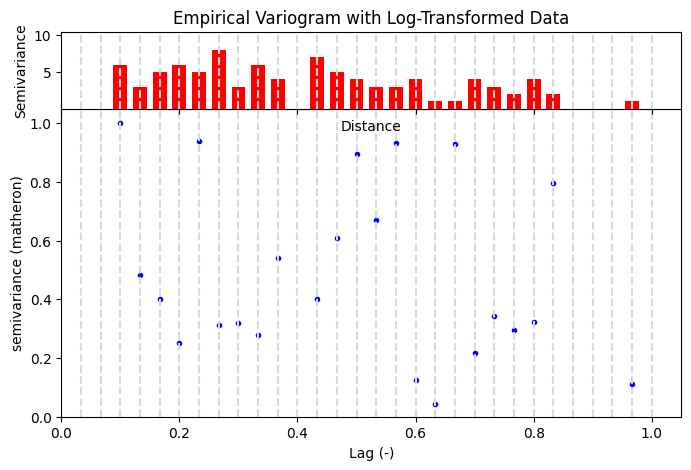

{'model': 'gaussian', 'estimator': 'matheron', 'dist_func': '__main__.haversine_dist', 'normalized_effective_range': 277.7149796608082, 'normalized_sill': 1.609301870188406e-07, 'normalized_nugget': 0.37962275627534087, 'effective_range': 0.7875090134895117, 'sill': 1.824582707220497e-07, 'nugget': 0.4304059599994607, 'params': {'estimator': 'matheron', 'model': 'gaussian', 'dist_func': '<function haversine_dist at 0x00000216697DBF60>', 'bin_func': 'even', 'normalize': True, 'fit_method': 'trf', 'fit_sigma': None, 'use_nugget': True, 'maxlag': None, 'n_lags': 30, 'verbose': False}, 'kwargs': {}}


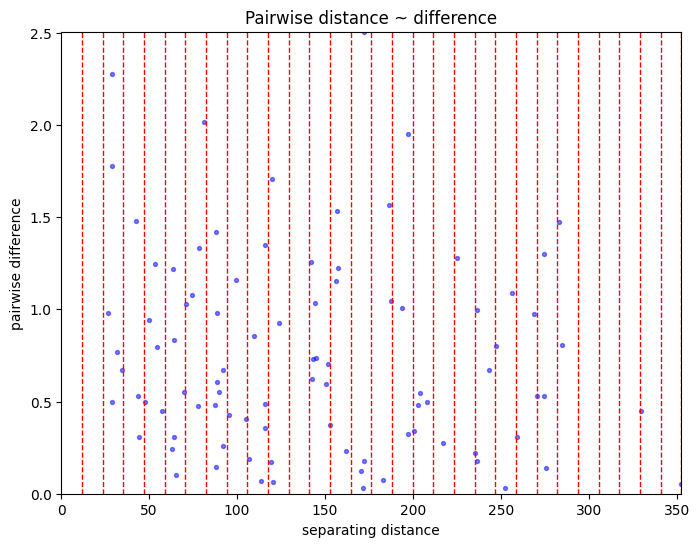

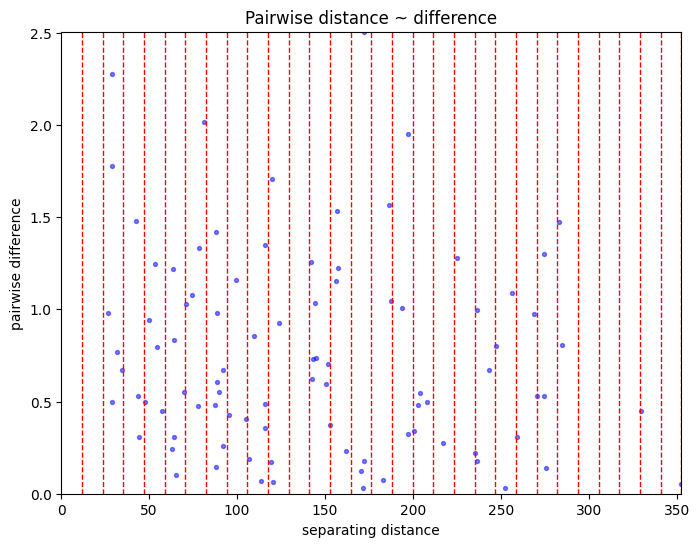

In [182]:
constant = 1e-5
week_201201_data_droped['precipitation_max_log'] = np.log(week_201201_data_droped['precipitation_max'] + constant)

# 2. Identify and Remove Outliers
# Using Z-score method to identify outliers
z_scores = np.abs(stats.zscore(week_201201_data_droped['precipitation_max_log']))
print(z_scores)
week_201201_data_droped = week_201201_data_droped[z_scores < 3]  # Removing outliers with Z-score > 3

# 3. Create the Variogram with Transformed Data
lat_lon_values_stations = week_201201_data_droped[['lat', 'lon']].values
print(lat_lon_values)
levels_log_prece = week_201201_data_droped['precipitation_max_log'].values.flatten()
print(levels_log)

V_log_new = skg.Variogram(
    lat_lon_values_stations,
    levels_log_prece,
    maxlag='auto',
    n_lags=30,
    use_nugget=True,
    normalize=True,
    dist_func=haversine_dist  # Ensure this is suitable for your data
)

V_log_new.model = 'gaussian'  # You can try 'gaussian' or 'exponential'
V_log_new.fit()
V_log_new.describe()
# 4. Plot the Variogram
fig = V_log_new.plot(show=False)
plt.title('Empirical Variogram with Log-Transformed Data')
plt.xlabel('Distance')
plt.ylabel('Semivariance')
plt.show()

# 5. Print description for further analysis
print(V_log_new.describe())
fig = V_log_new.distance_difference_plot(show=False)
fig

Graph Breakdown:
X-axis (Separating Distance): This represents the geographic distance between pairs of locations. Each point on the X-axis shows how far apart two points are in kilometers.
Y-axis (Pairwise Difference): This shows the difference between the precipitation measurements at two locations. A higher value means the precipitation values are very different, while a lower value means they are more similar.
Example to Explain:
Imagine you are working with data from several weather stations in a region. These stations measure precipitation in millimeters (mm) over time. Now, let's consider three example weather stations:

Station A: Location (0 km) with precipitation of 10 mm.
Station B: 50 km away from Station A with precipitation of 12 mm.
Station C: 200 km away from Station A with precipitation of 5 mm.
Now, let's look at what would happen when we plot the pairwise differences (the difference in precipitation) against the separating distance (the distance between stations).

1. Pair A and B:
Separating Distance: Station A is 0 km, and Station B is 50 km away.
Difference in Precipitation: The difference between 10 mm (A) and 12 mm (B) is 2 mm.
Plot Point: You would plot a point at (50, 2), meaning for a separating distance of 50 km, the pairwise difference in precipitation is 2 mm.
2. Pair A and C:
Separating Distance: Station A is at 0 km, and Station C is 200 km away.
Difference in Precipitation: The difference between 10 mm (A) and 5 mm (C) is 5 mm.
Plot Point: You would plot a point at (200, 5), meaning for a separating distance of 200 km, the pairwise difference in precipitation is 5 mm.
3. Pair B and C:
Separating Distance: Station B is at 50 km, and Station C is 200 km away.
Difference in Precipitation: The difference between 12 mm (B) and 5 mm (C) is 7 mm.
Plot Point: You would plot a point at (150, 7), meaning for a separating distance of 150 km, the pairwise difference in precipitation is 7 mm.
What the Graph Shows:
Clustering at Smaller Distances: You may notice that for small separating distances (e.g., under 50 km), the pairwise differences are generally lower, meaning stations that are closer together tend to have similar precipitation values. This makes sense because weather conditions are more alike in nearby locations.

More Spread at Larger Distances: As you move to larger separating distances (e.g., over 200 km), the pairwise differences tend to increase, meaning stations farther apart experience more variation in precipitation. This reflects how geographic distance impacts how similar or different the weather conditions can be.

Interpretation in Spatial Statistics (Variogram Context):
Spatial Correlation: The graph is a starting point for understanding spatial correlation. Stations close to each other (with small separating distances) tend to have more similar precipitation values, while those far apart have larger differences.
Building a Variogram: To predict precipitation at unknown locations, you'll use this spatial pattern of differences. The variogram helps model how the correlation between data points decreases as distance increases.
In summary:

The X-axis shows the distance between weather stations (or geographic points).
The Y-axis shows how different their precipitation measurements are.
Closer stations have smaller differences in precipitation (they tend to be more correlated), and as the distance increases, the differences tend to grow larger.

When creating a variogram for spatial data (like precipitation), understanding the role of both small and large distance data points is crucial, especially if you plan to use the variogram for kriging interpolation. Let's break this down.

Why Consider Larger Distance Data Points?
Spatial Correlation Over Distance:
The variogram is designed to capture how spatial correlation (similarity) decreases as distance increases. At small distances, points are usually highly correlated, meaning their values are similar (small pairwise differences).
At larger distances, the correlation tends to drop, meaning data points are less similar (larger pairwise differences). Including these larger distances helps the variogram model the complete range of how precipitation patterns change over distance.
Fitting a Complete Variogram Model:
A variogram typically has three important components:
Nugget: Represents variability at very small distances (including measurement error).
Sill: The point where the variogram levels off, indicating that after a certain distance, data points are no longer correlated (i.e., precipitation measurements at two points become independent).
Range: The distance at which the variogram reaches the sill, indicating the extent of spatial dependence.
If you remove large distance data points (like the 200 km, 5 mm difference in the example), the variogram might not fully capture the "range" — the point at which data points become uncorrelated. Without this information, the model may falsely assume that spatial correlation extends farther than it actually does, resulting in biased predictions in kriging.
Effect of Removing Larger Distance Points:
Short-range focus: If you exclude larger distances (like the 200 km point), your variogram will mostly capture short-range spatial dependencies. This can lead to overestimating spatial correlation at medium to large distances. In other words, kriging would "stretch" the influence of nearby points too far, potentially causing larger errors when predicting at unknown locations that are further away from your observed points.

Biased Predictions: If the region where you want to make predictions (through kriging) includes locations that are far from observed points, removing larger distance data will make your kriging interpolation less accurate. The kriging algorithm will not properly account for how quickly the correlation decays with distance, potentially leading to larger errors in your precipitation estimates.

Key Considerations:
Range: The variogram needs to capture the true range — the point where data points no longer show spatial dependence. If large-distance points are excluded, you may underestimate the range, leading to less reliable kriging predictions at medium-to-large distances.

Sill: Excluding large-distance points may make it harder to accurately determine the sill (the point where the variogram flattens). This could cause kriging to overweight distant points when they shouldn't be contributing much to the prediction.

Kriging Interpolation: The kriging algorithm uses the variogram to estimate values at unknown points based on the spatial correlation. If your variogram is incomplete (due to missing large-distance data), kriging will underestimate the uncertainty at distant locations, leading to poor accuracy.

When Might You Exclude Large-Distance Points?
Non-representative large distances: If you have reason to believe that large-distance points are influenced by factors that don't affect your area of interest (e.g., different climate regions), you could exclude them. However, this decision must be carefully justified to avoid introducing bias.

Sparse data: If your dataset contains very few points at large distances, the estimates of correlation at those distances may not be reliable. In such cases, you might consider removing those points, but this should be balanced against the need to capture long-range variability.

Recommendations:
Keep Larger Distance Points (like 200 km, 5 mm): These are important for modeling how precipitation correlation decreases with distance and for fitting a more accurate variogram.

Fit a Complete Variogram Model: Include both small and large distance points to ensure the variogram captures the true spatial structure of your data. This will improve the reliability of your kriging predictions, especially when interpolating over larger areas.

Conclusion:
Removing large-distance data points will likely result in less accurate kriging predictions, especially for points further from known locations. To minimize errors in precipitation interpolation, it’s best to include data points over a range of distances, ensuring the variogram fully captures the spatial structure of your dataset.

Let me know if you need further clarification or if you'd like help with fitting a variogram or performing kriging!








In [172]:
# Define the models to test
models = ['spherical', 'exponential', 'gaussian']

# Initialize variables to store the best model and its MSE
best_model = None
best_mse = float('inf')

# Iterate over each model
for model in models:
    # Create the variogram
    V_test = skg.Variogram(
        lat_lon_values,
        levels_log,
        model=model,
        maxlag='median',
        n_lags=N,
        dist_func=haversine_dist
    )
    
    # Fit the variogram model
    V_test.fit()
    
    # Calculate the mean squared error (MSE)
    mse = V_test.describe()['mse']
    
    # Update the best model if the current model has a lower MSE
    if mse < best_mse:
        best_mse = mse
        best_model = model

# Print the best model and its MSE
print(f"Best model: {best_model} with MSE: {best_mse}")

# Create the variogram with the best model
V_best = skg.Variogram(
    lat_lon_values,
    levels_log,
    model=best_model,
    maxlag='median',
    n_lags=N,
    dist_func=haversine_dist
)

# Fit the best variogram model
V_best.fit()

# Plot the best variogram
fig = V_best.plot(show=False)
plt.title(f'Empirical Variogram with Best Fit Model: {best_model}')
plt.xlabel('Distance')
plt.ylabel('Semivariance')
plt.show()

# Print the description for further analysis
print(V_best.describe())
fig = V_best.distance_difference_plot(show=False)
fig

KeyError: 'mse'

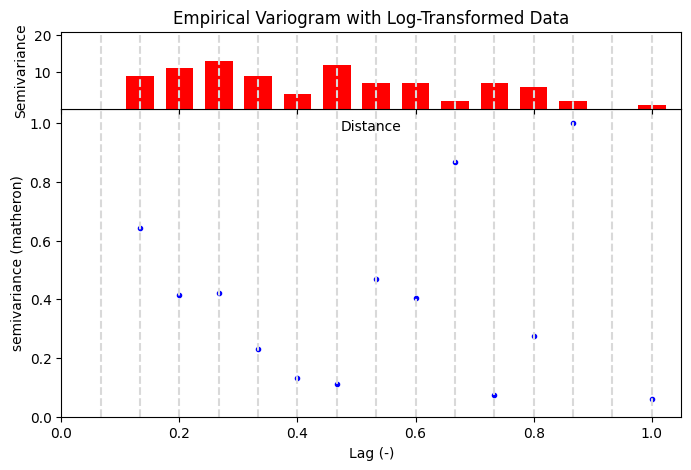

{'model': 'spherical', 'estimator': 'matheron', 'dist_func': '__main__.haversine_dist', 'normalized_effective_range': 13483.75949221049, 'normalized_sill': 175241.00836759017, 'normalized_nugget': 0, 'effective_range': 38.235539720650664, 'sill': 262.38004516850106, 'nugget': 0, 'params': {'estimator': 'matheron', 'model': 'spherical', 'dist_func': '<function haversine_dist at 0x00000216697DBF60>', 'bin_func': 'even', 'normalize': True, 'fit_method': 'trf', 'fit_sigma': None, 'use_nugget': False, 'maxlag': 350000, 'n_lags': 15, 'verbose': False}, 'kwargs': {}}


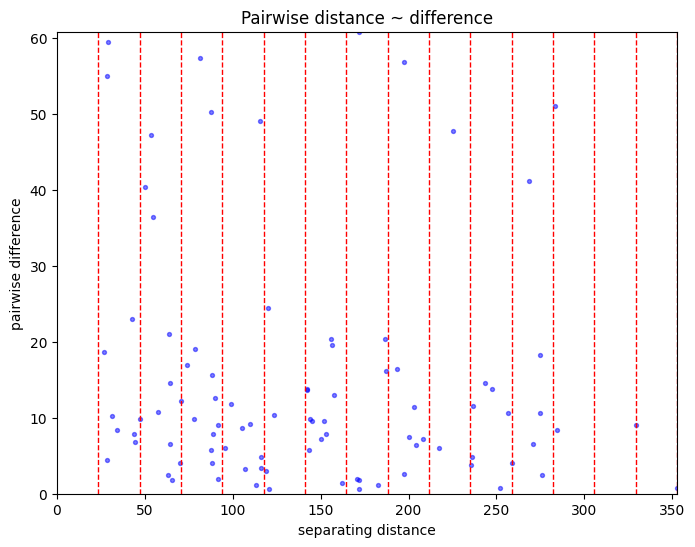

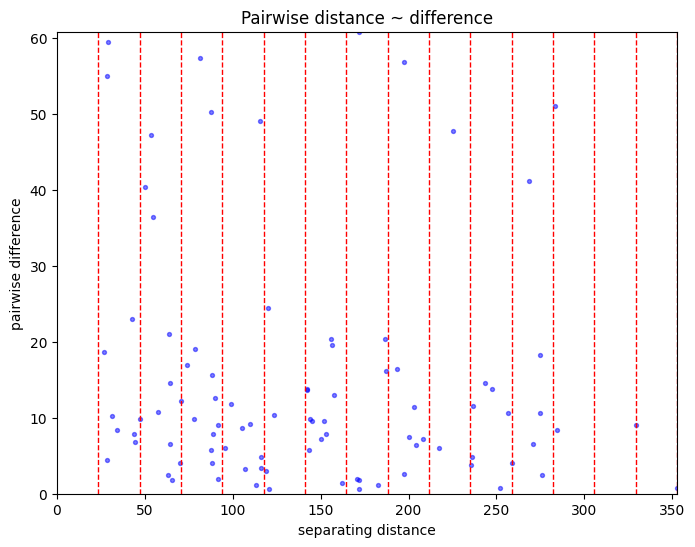

In [183]:
V_log_new = skg.Variogram(
    week_201201_data_droped[['lat', 'lon']].values,
    week_201201_data_droped[['precipitation_max']].values.flatten(),
    maxlag=350000,
    n_lags=15,
    normalize=True,
    dist_func=haversine_dist  # Ensure this is suitable for your data
)
V_log_new.fit()  # Experiment with other models if necessary

# 4. Plot the Variogram
fig = V_log_new.plot(show=False)
plt.title('Empirical Variogram with Log-Transformed Data')
plt.xlabel('Distance')
plt.ylabel('Semivariance')
plt.show()

# 5. Print description for further analysis
print(V_log_new.describe())
fig = V_log_new.distance_difference_plot(show=False)
fig